# Assignment 9 - Feature learning & selection
This week, we'll go over some ways in which one may lower the amount of features used for training even without domain expertise, i.e., without being able to select them manually based on one's understanding of the relationships between the features and the label. There are multiple reasons one might want to use less features in training: 
* to prevent overfitting (improving the ratio of training samples to features)
* to decrease computational complexity (faster training and prediction)
* visualizing high-dimensional data

In particular, we'll start off by looking at a method used even outside of machine learning called Principal component analysis (PCA) and use it to analyse and train on the MNIST dataset. Then we'll take a look at the Lasso and compare them. ### TODO: Possibly, At the end, we show parts of sklearn.feature_selection ###

## Learning goals
After this assignment, you should
* understand why one might want to use a lower number of features
* understand PCA on an intuitive level
* be aware of the pitfalls of using PCA in machine learning
* know what is Lasso and how it relates to Ridge regression
* be able to use Lasso to select a subset of features

## Principal Component Analysis (PCA)
You can think of Principal component analysis as finding a linear subspace of a given dimension (line, plane, hyperplane,...) that is the best fit of high-dimensional vectors. In this case, by best fit we mean that we minimize the squares of the distances of the vectors from the subspace, which corresponds to the information that we'll lose by this method.

If you recall how linear regression works, this may sound familiar. The difference is that linear regression studies functional dependence of the label on the features (how to fit a linear predictor), while PCA does not take the labels into account, it is only concerned about the features. The exact formulations are out of scope of this assignment but for visualizations, see for example [this link](https://www.r-bloggers.com/2010/09/principal-component-analysis-pca-vs-ordinary-least-squares-ols-a-visual-explanation/). 

There are a few pitfalls to PCA that you should be aware of:
* If we set the dimensions of the subspace too low, we may lose too much information to make any reasonable predictions.
* The features generated by PCA are a linear combination of the original features and there's likely no way to interpret them. Imagine a dataset where you try to predict car brand based on engine power and price. Using PCA to reduce the features to 1 might leave us with a feature "0.9\*price-0.1\*power", which doesn't have any real-world meaning. 
* Since PCA doesn't take labels into account, it is entirely possible that the selected features will not be optimal for predicting the labels.
* PCA is very sensitive to statistical properties of the different dimensions (=features).

All of these will be illustrated below.

### MNIST
We begin by fetching the MNIST dataset. This dataset contains 70000 B&W images with resolution 28x28 pixels. Each pixel represents a shade of grey as an 8bit integer (range 0-255) and each image represents a handwritten digit. This leads to a 10-class classification problem, where the goal is to predict the digit based on pixel intensities.

Below we fetch the datset and view one representative of each class to familiarize ourselves with the dataset.

In [1]:
# Import basic libraries needed for this assignment
%config Completer.use_jedi = False  # enable code auto-completion
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

# load the MNIST dataset
X_MNIST, y_MNIST = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


In [2]:
print(X_MNIST)
print(y_MNIST)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['5' '0' '4' ... '4' '5' '6']


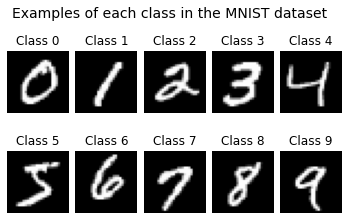

In [3]:
# plot the numbers in two rows
def plot_digits(X,y,cols=5,title=None):
    cols = 5
    fig, axs = plt.subplots(2, cols)
    plt.axis('off')
    for digit in range(10):
        # find the first representative of the label
        idx = np.argwhere(y == str(digit))[0]

        # change the vector into a 2D array and plot it
        im = X[idx].reshape(28, 28)
        axs[digit//cols, digit % cols].set_title(f'Class {digit}')
        axs[digit//cols, digit % cols].imshow(im, cmap='gray')
        axs[digit//cols, digit % cols].axis('off')

    # change the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=-0.3)
    if title is not None:
        fig.suptitle(title,fontsize=14)
        fig.subplots_adjust(top=0.97)
    
plot_digits(X_MNIST,y_MNIST,title="Examples of each class in the MNIST dataset")
plt.show()


### Demo: PCA, before and after
Below, we use Logistic Regression like we're used to, to predict the digits. Even though the images have a rather low resolution, training the model on more than a couple hundred images quickly becomes very computationally demanding and can take a couple of minutes. Performing a grid search to find the optimal parameters could thus easily take over an hour.

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_MNIST, y_MNIST, test_size=0.33, random_state=42)

clf = LogisticRegression(solver='liblinear' )
clf.fit(X_train[:200], y_train[:200])
# can increase training data to reach 91.7 % but it takes 10 minutes on my computer


LogisticRegression(solver='liblinear')

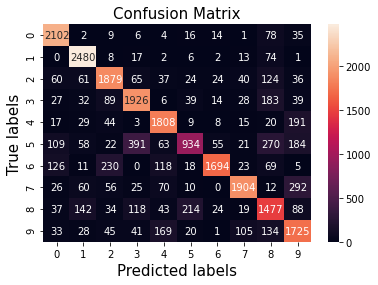

Prediction accuracy: 77.61%


In [5]:
def generate_confusion_matrix(y_true, y_pred):
    # visualize the confusion matrix
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)

y_pred = clf.predict(X_val)
generate_confusion_matrix(y_val, y_pred)
plt.show()

# compute the accuracy
multi_accuracy = accuracy_score(y_val, y_pred)
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")


#### With PCA
First, we fit the PCA to the training data. By setting the ``n_components`` parameter, we can choose the dimension of the fitted subspace (=number of output features). A perhaps surprising result is that having computed the PCA, it is very simple to lower the amount of features further: the most important feature (in the PCA sense) is the first one, the most important two are the first two,... 

One way to decide how many components to use is to look at the explained variance ratio of each of the features. These correspond to the "importance" of each feature. Let's plot these:

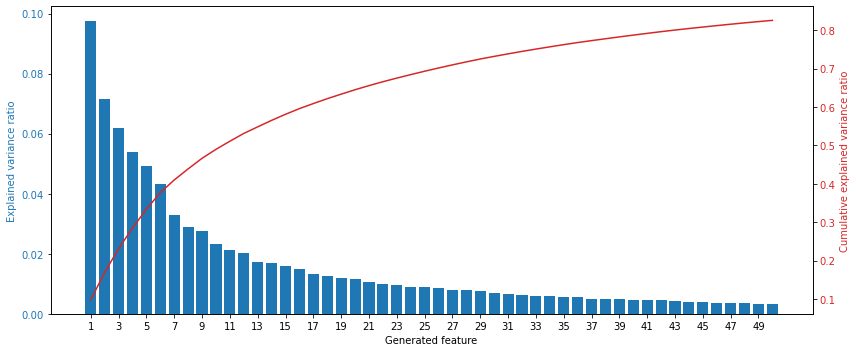

In [6]:
# fit the PCA
N = 50
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()


If we choose to use 784 components, then the cumulative explained variance ratio will be 1, i.e., no data would be lost. This corresponds to projecting the data to the same space where it originally "lived", i.e. not doing anything. Note, however, that the features will likely still change, even though no data is lost. What happens is essentially a change of basis of the feature space. 

Of course, there's not much use in keeping all the features, so how many features (components) should we keep? There's no clear cut answer to that here and there rarely is. In this case, let's keep 15 components, because the explained variance ratio drops to under 2% per feature around that point. 

In [7]:
N = 15
pca.set_params(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

Now let's visually confirm that the compression hasn't affected the pictures too much. Based on the representatives chosen, it seems that keeping just 15/784 dimensions still leaves the digits legible, if slightly blurry.

To view the image after dropping the less important features, we need to transform the 15-dimensional vector back into the original 784-dimensional space. For this, we'll use the ``inverse_transform`` method. Mathematically, all of the components form a basis of the original space, so this function creates a linear combination of the first 15 basis vector with coefficients corresponding to the new features.

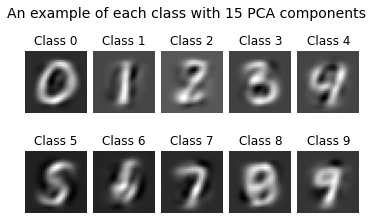

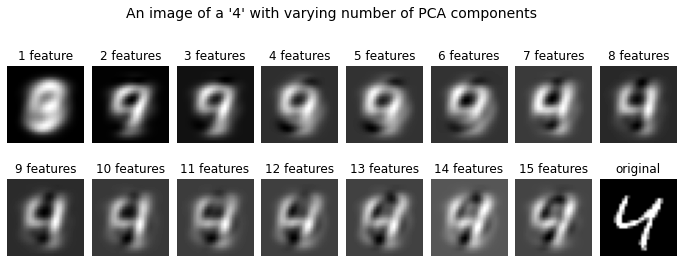

In [8]:
# plot the digits with only 15 components
plot_digits(pca.inverse_transform(X_train_reduced), y_train, title="An example of each class with 15 PCA components")
plt.show()

# plot the same picture with different numebrs of features
digit = 4
cols = 8
fig, axs = plt.subplots(2, cols, figsize=(12, 8))
fig.suptitle("An image of a '4' with varying number of PCA components", fontsize=14)
idx = np.argwhere(y_train == str(digit))[0]
for n in 1+np.arange(N):
    X_nfeatures = X_train_reduced[idx]*[1 if i < n else 0 for i in range(N)]
    # transform the data back into the original 784-dimensional space
    im = pca.inverse_transform(X_nfeatures).reshape(28, 28)
    # plot it
    axs[(n-1)//cols, (n-1) % cols].set_title(f"{(n)} feature{'s' if n>1 else ''}")
    axs[(n-1)//cols, (n-1) % cols].imshow(im, cmap='gray')
    axs[(n-1)//cols, (n-1) % cols].axis('off')
# plot the original
axs[-1, -1].set_title(f'original')
axs[-1, -1].imshow(X_train[idx].reshape(28, 28), cmap='gray')
axs[-1, -1].axis('off')
# adjust spacing
fig.subplots_adjust(wspace=0.1, hspace=-0.8, top=1.3)
plt.show()


<div class=" alert alert-warning">

# Student Task A9.1
Use the transformed data ``X_train_reduced`` to train a logistic regressor. Then compute its accuracy on the validation set. Do not forget what variables have already been transformed using PCA and which still need to have it applied. 
<div>

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Prediction accuracy: 77.61%


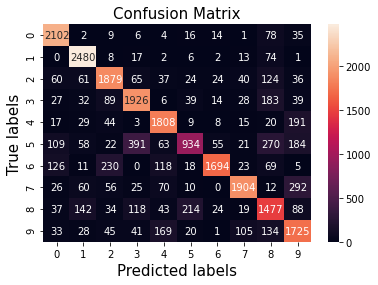

In [9]:
clf_2 = LogisticRegression(solver='sag')# create the object, SET solver='sag'
clf_2.fit(X_train_reduced[:400],y_train[:400]) # fit the data
y_pred = clf.predict(X_val) #compute the prediction on the validating set
multi_accuracy = accuracy_score(y_val, y_pred)# compute the accuracy score

print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")
generate_confusion_matrix(y_val, y_pred)
plt.show()

assert isinstance(clf_2, LogisticRegression), "You need to use Logistic regression!"


In [10]:
## test cell for A9.1


In [11]:
## test cell for A9.1


## Demo: Data visualization
Another application of PCA is visualization of high-dimensional data. Here, we plot each image as a single point based on its coordinates in the 2D subspace generated by PCA. For example, we can see that 1's seem to be very easy to tell apart and they all look very similar, whereas these two dimensions are certainly not enough to tell apart 4's and 9's in any meaningful way. This confirms what we saw earlier - with only a few components, the 4 looked like a 9!

Note that since the features carry no meaning anymore, we label the axes simply as PCA1 and PCA2.

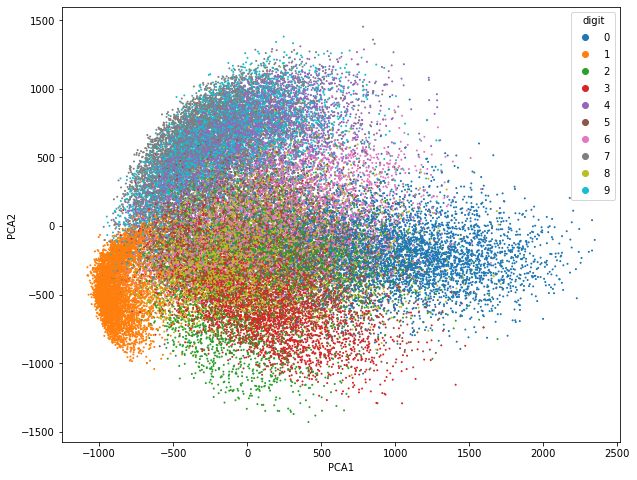

In [12]:
plt.figure(figsize=(10, 8))
# convert the labels to numbers, each will be assigned a separate color based on the cmap specified
colors = [int(x) for x in y_train]
sc = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], s=1, c=colors, cmap='tab10')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(*sc.legend_elements(), title='digit')
plt.show()


## Lasso
Another way of "automatically" lowering the number of features is known as Lasso. An advantage it has over PCA is that it takes the labels into account too. Furthermore, you do not lose intepretability of the resulting features: these will simply be a subset of the original features.

The Lasso is actually just linear regression with L1 regularization (in the same way that that in A6 we used Ridge - L2 regularization). That means that the squared error loss is replaced by
$$
L((\mathbf{x},y),h^{(\mathbf{w})})=(y-\mathbf{w}^T\mathbf{x})^2+\lambda\|\mathbf{w}\|_1.
$$
By varying parameter $\lambda$, we influence the number of features that will have zero weights in the resulting trained model.

The reason why using L1 regularization would typically lead to sparse ("many zeros") solutions is not immediately clear. The animation below (courtesy of [Itay Evron](https://github.com/ievron/RegularizationAnimation/)) could give you an intuition (along with the description underneath):

![Regularization](regularization.gif "regularization")

*The unit "circles" (points with norm $\leq1$) are shown in turquoise. Notice that in the 1-norm case (on the right), the unit circle is actually a square rotated by 45 degrees. Convince yourself this is indeed the case when*
$$
\|(x,y)\|_1=|x|+|y|.
$$
*In grey, you can see the optimal value of the loss function (the center of the ellipses), each of the ellipses marks a countour line (curve where the loss assumes the same value). As the loss function changes (this corresponds to changing the training data), you can watch how does the orange point, which is the optimum on the unit circle, behaves. You can notice that in the case of L1 regularization, it is much more often on one of the axes, meaning that one of the weights is zero.*

### Demo: Comparison of Lasso and Ridge
Now let's study how Lasso compares to Ridge. The dataset we use for training is the same we used when we studied ridge regression originally (in A6): noisy sinusoidal data. We will use polynomial features of degree 10 and look at how the penalty coefficient affects the resulting model.

The first plot compares how the error depends on parameter ``alpha`` and is not of very high importance here. In the plots that follow, you can observe how increasing the penalty weight, lasso tends to decrease the importance of features one at a time, while with ridge, this affects all features mostly similarly. Also notice that lasso makes the feature weights truly zero, this never truly happens with ridge, where they simply get very close to zero but never quite reach it.

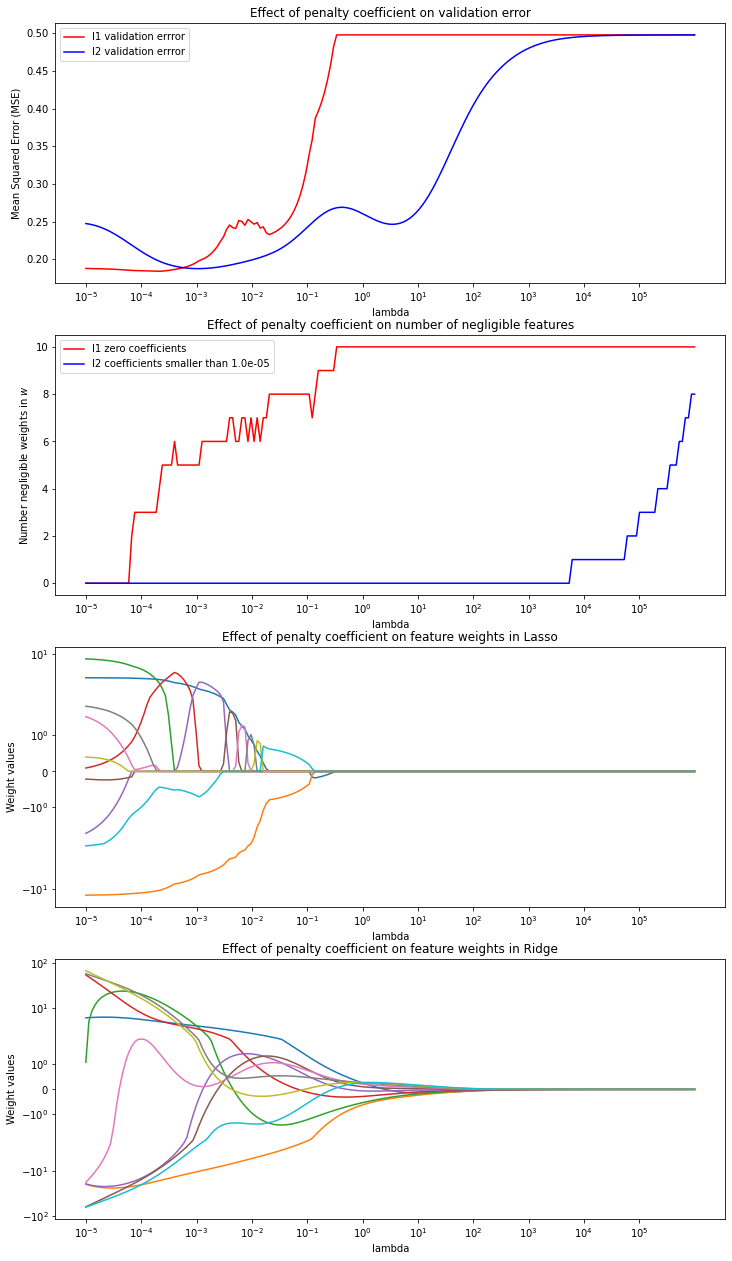

In [13]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
interval = [0, 7]


def make_data(m=30):
    # generate datapoints with a noisy sinusoidal relationship
    np.random.seed(seed=1)
    X = (interval[1]-interval[0])*np.random.rand(m, 1)+interval[0]
    y = np.sin(X)+0.5*np.random.randn(m, 1)
    return X, y


def train_validate_poly(X_train, y_train, X_val, y_val, model, degree=10):
    # train a polynomial model and validate it

    # generate polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_val_poly = poly_features.fit_transform(X_val)

    # learn the model and validate it
    scaler = StandardScaler().fit(X_train_poly)
    reg = model().fit(scaler.transform(X_train_poly), y_train)
    y_val_pred = reg.predict(scaler.transform(X_val_poly))
    val_err = mean_squared_error(y_val, y_val_pred)
    return reg, val_err


X2, y2 = make_data(50)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.33, random_state=2)

# iteratively try different lambdas
l_range = (-5, 6)
l1_errs = []
l1_regs = []
l2_errs = []
l2_regs = []
lambdas = np.logspace(*l_range, num=200)  # candidate lambdas
for l in lambdas:
    reg, val_err = train_validate_poly(
        X2_train, y2_train, X2_val, y2_val, lambda: Lasso(alpha=l, max_iter=20000))
    l1_regs.append(reg)
    l1_errs.append(val_err)

    reg, val_err = train_validate_poly(
        X2_train, y2_train, X2_val, y2_val, lambda: Ridge(alpha=l))
    l2_regs.append(reg)
    l2_errs.append(val_err)

# plot the data
fig, axs = plt.subplots(4, 1, figsize=(12, 22))
plt.setp(axs, xscale='log', xticks=[10**x for x in range(*l_range)], xlabel='lambda', ylabel='Mean Squared Error (MSE)')
axs[0].plot(lambdas, l1_errs, color='red', label='l1 validation errror')
axs[0].plot(lambdas, l2_errs, color='blue', label='l2 validation errror')
axs[0].set_title('Effect of penalty coefficient on validation error')
axs[0].legend()

axs[1].set_title("Effect of penalty coefficient on number of negligible features")
axs[1].set_ylabel('Number negligible weights in $w$')
axs[1].plot(lambdas, [sum(r.coef_ == 0) for r in l1_regs], color='red', label='l1 zero coefficients')
axs[1].plot(lambdas, [sum(abs(r.coef_[0]) < 1e-5) for r in l2_regs], color='blue', label=f'l2 coefficients smaller than {1e-5:.1e}')
axs[1].legend()

plt.setp(axs[2:], yscale='symlog')
l1_weights = np.array([r.coef_ for r in l1_regs])
l2_weights = np.array([r.coef_[0] for r in l2_regs])
axs[2].set_title("Effect of penalty coefficient on feature weights in Lasso")
axs[2].plot(lambdas, l1_weights)
axs[2].set_ylabel("Weight values")
axs[3].plot(lambdas, l2_weights)
axs[3].set_title("Effect of penalty coefficient on feature weights in Ridge")
axs[3].set_ylabel("Weight values")

plt.show()


<div class=" alert alert-warning">

# Student Task A9.2
Take a look at the plots above. Answer the following questions:
* Q1: By looking at the plots above, it is certain that the model resulting from lasso with ``alpha=1e-2`` is a degree 10 polynomial in ``x``.
    * ``A1=0``: disagree, ``A1=1``: agree.
* Q2: By looking at the plots above, it is certain that the model resulting from ridge with ``alpha=1e-2`` is a degree 10 polynomial in ``x``.
    * ``A2=0``: disagree, ``A2=1``: agree.
* Q3: What is the reason the validation MSE error is similar for high ``alpha`` (see the first plot) for Lasso and Ridge?
    * ``A3=0``: Both models approach the same function as ``alpha`` goes to infinity.
    * ``A3=1``: This is just a coincidence.
    * ``A3=2``: For high values of ``alpha``, the norms converge.
</div>

In [39]:
A1 = 1
A2 = 0
A3 = 2

assert A1 in {0, 1}
assert A2 in {0, 1}
assert A3 in {0, 1, 2}


In [15]:
## test cell for A9.2


In [16]:
## test cell for A9.2


In [17]:
## test cell for A9.2


### Demo: PCA ignores the labels
Lasso can also help us when PCA fails. To show this, we'll create an artificial dataset with two randomly generated features with significantly different scales (=variances). The labels will depend on the feature with lower variance. PCA, which ignores the labels, will then do what it's supposed to: find a 1D subspace that fits the data the best, which, in this case, roughly means keeping the irrelevant feature. This is because in some sense, PCA measures the importance by variance.

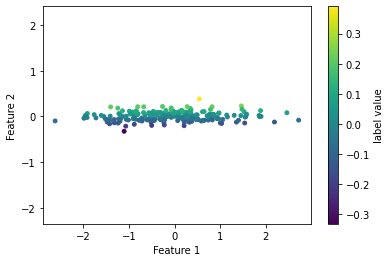

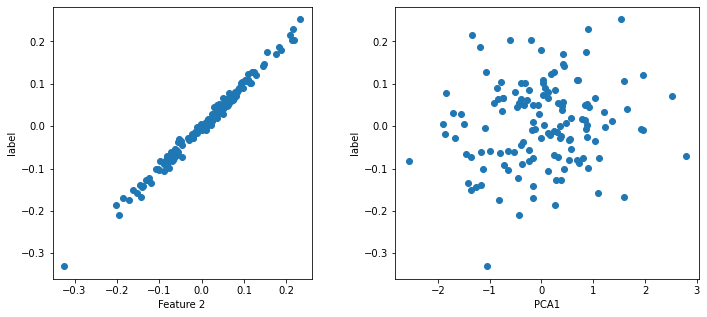

In [18]:
def generate_dataset(n=200, f1_scale=1, f2_scale=0.1, label_noise_scale=0.01):
    np.random.seed(seed=42)
    # generate the two features
    feature1 = np.random.normal(scale=f1_scale, size=(n, 1))
    feature2 = np.random.normal(scale=f2_scale, size=(n, 1))
    X = np.concatenate((feature1, feature2), axis=1)
    # generate the labels by adding noise to feature 2
    y = feature2+np.random.normal(scale=label_noise_scale, size=(n, 1))
    return X, y


X3, y3 = generate_dataset()
# visualize the dataset
sc = plt.scatter(X3[:, 0], X3[:, 1], s=15, c=[y3])
cbar=plt.colorbar()
cbar.set_label("label value")
plt.axis('equal')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# do PCA
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=0.33, random_state=42)
pca = PCA(n_components=1).fit(X3_train)
X3_1D_train = pca.transform(X3_train)

# plot label wrt. feature 2
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X3_train[:, 1], y3_train)
axs[0].set_xlabel("Feature 2")
axs[0].set_ylabel("label")
axs[0].set_aspect('equal', 'box')

# plot label wrt. generated feature
axs[1].scatter(X3_1D_train, y3_train)
axs[1].set_xlabel("PCA1")
axs[1].set_ylabel("label")

plt.show()

<div class=" alert alert-warning">

# Student Task A9.3
Find a value of ``alpha`` so that precisely one of the coefficients is nonzero after training on this dataset.
<div>

In [40]:
# could be a task for students: find alpha such that lasso has precisely one nonzero weight

l_range = (-3,3)
lambdas = np.logspace(*l_range,num=200) # candidate lambdas
for lam in lambdas:
    # could be a task for students: find alpha such that lasso has precisely one nonzero weight
    lasso =  Lasso(alpha=lam, max_iter=20000)   # create a Lasso object with alpha as the parameter
    lasso.fit(X3_train, y3_train)  # fit X3_train and y3_train
    print(lam)
    print(f"Coefficients are {lasso.coef_}")
    print(f"Prediction MSE: {mean_squared_error(lasso.predict(X3_val), y3_val):.3f}")

    
alpha = 0.001# set alpha
lasso = Lasso(alpha=alpha, max_iter=20000) # create a Lasso object with alpha as the parameter
lasso.fit(X3_train,y3_train) # fit X3_train and y3_train
print(f"Coefficients are {lasso.coef_}")

print(f"Prediction MSE: {mean_squared_error(lasso.predict(X3_val), y3_val):.3f}")


0.001
Coefficients are [0.         0.89881575]
Prediction MSE: 0.000
0.0010718913192051276
Coefficients are [0.         0.89142544]
Prediction MSE: 0.000
0.0011489510001873086
Coefficients are [0.         0.88350383]
Prediction MSE: 0.000
0.0012315506032928262
Coefficients are [0.         0.87501273]
Prediction MSE: 0.000
0.001320088400831418
Coefficients are [0.         0.86591119]
Prediction MSE: 0.000
0.0014149912974345759
Coefficients are [0.         0.85615533]
Prediction MSE: 0.000
0.0015167168884709225
Coefficients are [0.         0.84569811]
Prediction MSE: 0.000
0.0016257556664437934
Coefficients are [0.        0.8344891]
Prediction MSE: 0.000
0.0017426333860096508
Coefficients are [0.         0.82247427]
Prediction MSE: 0.000
0.0018679135990207828
Coefficients are [0.         0.80959567]
Prediction MSE: 0.000
0.0020022003718155844
Coefficients are [0.         0.79579121]
Prediction MSE: 0.000
0.0021461411978584036
Coefficients are [0.         0.78099433]
Prediction MSE: 0.001

In [ ]:
## test cell for A9.3


In [ ]:
## test cell for A9.3


## Demo: Recursive feature elimination
There are also many methods for [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) already implemented in ``sklearn``. Here, we will take a quick look at Recursive feature elimination (RFE).

Given an external estimator (e.g. Logistic Regression), RFE iteratively drops the "least important" feature(s) after fit. In the case of Logistic Regression, the feature(s) dropped will be the feature(s) corresponding to the weight(s) that has (have) the smallest absolute value. 

Below, you can see that according to RFE, the most important pixels seem to be those in the middle of the image, which is rather unsurprising - in this case, this is clear to a human that this would be the case. This approach can thus be useful when we do not have a good understanding of the relationships between the features and labels.

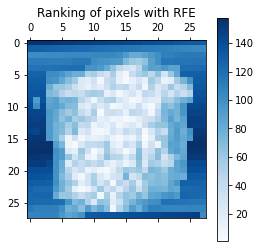

In [38]:
from sklearn.feature_selection import RFE
estimator=LogisticRegression(solver='liblinear')
rfe=RFE(estimator,n_features_to_select=1,step=5)
rfe.fit(X_MNIST[:100],y_MNIST[:100])

ranking = rfe.ranking_.reshape((28,28))

# plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()